In [1]:
import torch as th
import torch.nn as nn
import numpy as np
import random
import load_data
import utils
import re

In [2]:
th.manual_seed(1234)

In [3]:
class ConvModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvModel, self).__init__()
        self.out_channels = out_channels
        
        self.conv1 = nn.Conv2d(in_channels, self.out_channels, kernel_size=(5,5), padding=2)
        self.rel_conv1 = nn.ReLU()
        
        #kernel_pool = (3,3)
        #self.pool = nn.MaxPool2d(kernel_pool, stride=1, padding=1)
        
    def forward(self, data):
        # data.size() = (1, in_channels, w, h)
        out = self.conv1(data)
        out = self.rel_conv1(out)
        
        #out = self.pool(out)
        
        # out.size() = (1,self.out_channels, w, h)
        # squeeze(0) -> (self.out_channels, w, h)
        # permute(1, 2, 0) -> (w, h, self.out_channels)
        out = out.squeeze(0).permute(1, 2, 0)
        return out.contiguous().view(-1, self.out_channels)

In [4]:
class LinModel(nn.Module):
    def __init__(self, out_channels):
        super(LinModel, self).__init__()
        self.out_channels = out_channels
        
        self.lin1 = nn.Linear(self.out_channels, self.out_channels * 2)
        self.act1 = nn.ReLU()
        
        self.lin2 = nn.Linear(self.out_channels * 2, 2)
        self.act2 = nn.Softmax(dim=1)
        
    def forward(self, data):
        out = self.lin1(data)
        out = self.act1(out)
        out = self.lin2(out)
        return self.act2(out)

In [5]:
class MyModel2(nn.Module):
    def __init__(self, in_channels):
        super(MyModel2, self).__init__()
        
        self.lin1 = nn.Linear(in_channels, in_channels * 3)
        self.rel = nn.ReLU()
        self.lin2 = nn.Linear(in_channels * 3, 2)
        self.act1 = nn.Softmax(dim=1)
        
    def forward(self, data):
        #out = data.squeeze(0).permute(1, 2, 0)
        #out = out.contiguous().view(-1, self.in_channels)
        out = self.lin1(data)
        out = self.rel(out)
        out = self.lin2(out)
        return self.act1(out)

In [6]:
limit_files_per_town = 5

In [7]:
img = load_data.load_images_in_path("./split_data/img_split_RGB_filtered", limit_files_per_town)
print("Nombre d'image de train : %d" % (len(img)))

Nombre d'image de train : 19


In [8]:
town_name_list = load_data.get_town_name_list(img)
print(town_name_list)

{'vienna'}


In [9]:
def dict_to_sorted_list(img_dict):
    return sorted(img_dict.items(), key=lambda t: t[0])

In [10]:
sorted_img = dict_to_sorted_list(img)

gt = load_data.load_images_in_path("./split_data/gt_split_filtered", limit_files_per_town)
sorted_gt = dict_to_sorted_list(gt)

print(sorted_img[0])
print(sorted_gt[0])
print(sorted_img[-1])
print(sorted_gt[-1])

('vienna2_17.jpg', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x7FD044884D30>)
('vienna2_17.jpg', <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1000x1000 at 0x7FD04489D128>)
('vienna4_16.jpg', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x1000 at 0x7FD044872FD0>)
('vienna4_16.jpg', <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1000x1000 at 0x7FD0448949E8>)


In [11]:
def make_train_valid_sets(sorted_train, sorted_gt, town_name_list):
    ratio = 0.8
    train_img_list = []
    train_gt_list = []
    valid_img_list = []
    valid_gt_list = []
    for (n1,img),(n2,gt) in zip(sorted_train, sorted_gt):
        if n1 != n2:
            print("not sorted !")
        if random.random() < ratio:
            train_img_list.append((n1,img))
            train_gt_list.append((n2,gt))
        else:
            valid_img_list.append((n1,img))
            valid_gt_list.append((n2,gt))
    return {"img":train_img_list, "gt":train_gt_list}, {"img":valid_img_list,"gt":valid_gt_list}

In [12]:
train, valid = make_train_valid_sets(sorted_img, sorted_gt, town_name_list)

In [13]:
def img_sorted_list_to_numpy(sorted_img_list):
    return [(np.moveaxis(np.asarray(img).astype(float), -1, 0)/255.)[np.newaxis,:,:,:] for _,img in sorted_img_list]

In [14]:
train_np = img_sorted_list_to_numpy(train["img"])

In [15]:
print(train_np[0].shape)

(1, 3, 1000, 1000)


In [16]:
print(np.asarray(train["gt"][0][1]).max())
print(np.asarray(train["gt"][0][1]).min())
print(np.asarray(train["gt"][0][1]))

255
0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


* classe building = 1
* classe non-building = 0

In [17]:
def gt_sorted_list_to_numpy(sorted_gt_img):
    return [np.where(np.asarray(gt).flatten() > 122, 1, 0) for _,gt in sorted_gt_img]

In [18]:
gt_np = gt_sorted_list_to_numpy(train["gt"])

In [19]:
print(gt_np[0].shape)
print(gt_np[0].max())
print(gt_np[0].min())
s = 0
t = 0
for y in gt_np:
    s += y.sum()
    t += y.shape[0]
print(s / t)
print(gt_np[0].shape)

(1000000,)
1
0
0.4462952777777778
(1000000,)


In [20]:
valid_img_np = img_sorted_list_to_numpy(valid["img"])
valid_gt_np = gt_sorted_list_to_numpy(valid["gt"])

In [22]:
print(len(train_np))
print(len(valid_img_np))
print(valid_img_np[0].max())
print(valid_img_np[0].min())

print(len(valid_img_np))

18
1
1.0
0.0
1


```python
img = load_one_image("austin1.jpg")
label = load_one_image("austin1_label.jpg")
```

```python
type(img)
```

```python
arr = np.asarray(img)
label = np.asarray(label)
```

```python
print(arr.shape)
print(label.shape)
```

```python
w = arr.shape[0]
h = arr.shape[1]
c = arr.shape[2]
arr = arr.reshape(1, c, w, h) 
label = label.flatten().reshape(-1 ,1)

print(label.shape)
```

```python
print(arr.shape)
```

In [23]:
tmp = list(zip(train_np, gt_np))
random.shuffle(tmp)
train_np, gt_np = zip(*tmp)

In [24]:
def compute_scores(model_conv, model_lin, valid_img_np, valid_gt_np):
    intersection = 0
    union = 0
    nb_build = 0
    total = 0
    same = 0
    for img, gt in zip(valid_img_np, valid_gt_np):
        pred = model_conv(utils.to_float_tensor(img))
        pred = model_lin(pred).detach().numpy()
        pred = pred.argmax(axis=1)
        
        same += (pred == gt).sum()
        
        intersection += np.sum(np.logical_and(gt, pred))
        union += np.sum(np.logical_or(gt, pred))
        
        nb_build += np.sum(gt)
        
        total += gt.shape[0]
        
    ratio = nb_build / total
    iou = intersection / union
    accuracy = same / total
    return ratio, accuracy, iou

In [ ]:
nbEpoch = 4
learning_rate = 1e-5

model_conv = ConvModel(3, 8)
model_lin = LinModel(8)
loss_fn = nn.NLLLoss()

if utils.use_cuda():
    model_conv.cuda()
    model_lin.cuda()
    loss_fn.cuda()

optim = th.optim.Adagrad(list(model_conv.parameters()) + list(model_lin.parameters()), lr=learning_rate)

for i in range(nbEpoch):
    sum_loss = 0
    
    for j, (img, gt) in enumerate(zip(train_np, gt_np)):
        model_conv.train()
        model_lin.train()
        
        out = model_conv(utils.to_float_tensor(img))
        
        batch_size = 1000
        splitted_out = th.split(out, batch_size, dim=0)
        splitted_gt = th.split(utils.to_long_tensor(gt), batch_size, dim=0)
        
        for o, y in zip(list(splitted_out), list(splitted_gt)):
            optim.zero_grad()
            
            out_batch = model_lin(o)
            loss = loss_fn(out_batch, y)
            
            loss.backward(retain_graph=True)
            optim.step()
            
            sum_loss += loss.item()
        
        model_conv.eval()
        model_lin.eval()
        ratio, acc, iou = compute_scores(model_conv, model_lin, valid_img_np, valid_gt_np)
        print("Epoch %d, image %d, accuracy = %f, iou = %f, ratio = %f" % (i, j, acc, iou, ratio))
    
    sum_loss /= len(train_np)
    ratio, acc, iou = compute_scores(model_conv, model_lin, valid_img_np, valid_gt_np)
    print("[Epoch %d] loss = %f, accuracy = %f, iou = %f, ratio = %f" % (i, sum_loss, acc, iou, ratio))

Epoch 0, image 0, accuracy = 0.595905, iou = 0.012425, ratio = 0.401289
Epoch 0, image 1, accuracy = 0.596380, iou = 0.010927, ratio = 0.401289
Epoch 0, image 2, accuracy = 0.596880, iou = 0.008756, ratio = 0.401289
Epoch 0, image 3, accuracy = 0.597035, iou = 0.008137, ratio = 0.401289
Epoch 0, image 4, accuracy = 0.597498, iou = 0.006080, ratio = 0.401289
Epoch 0, image 5, accuracy = 0.597721, iou = 0.005041, ratio = 0.401289
Epoch 0, image 6, accuracy = 0.597856, iou = 0.004177, ratio = 0.401289
Epoch 0, image 7, accuracy = 0.597964, iou = 0.003549, ratio = 0.401289
Epoch 0, image 8, accuracy = 0.597977, iou = 0.003495, ratio = 0.401289
Epoch 0, image 9, accuracy = 0.598000, iou = 0.003273, ratio = 0.401289
Epoch 0, image 10, accuracy = 0.598020, iou = 0.003154, ratio = 0.401289
Epoch 0, image 11, accuracy = 0.598105, iou = 0.002660, ratio = 0.401289
Epoch 0, image 12, accuracy = 0.598156, iou = 0.002487, ratio = 0.401289
Epoch 0, image 13, accuracy = 0.598245, iou = 0.002183, ratio

(2500, 2500, 3)


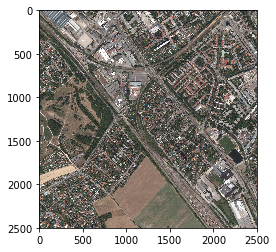

In [45]:
from matplotlib.pyplot import imshow
from PIL import Image
img_test = Image.open("./train/images/vienna36.jpg")
arr_test = np.asarray(img_test)
print(arr_test.shape)
imshow(arr_test)

In [48]:
x = np.moveaxis(np.asarray(arr_test), -1, 0)[np.newaxis,:,:,:]/255.
print(x.shape)

(1, 3, 2500, 2500)


In [49]:
model.eval()
y = model(to_float_tensor(x))

In [52]:
res = y.detach().numpy().argmax(axis=1)

In [55]:
h = arr_test.shape[0]
w = arr_test.shape[1]
print(res.shape)
gt_res = res.reshape(h,w)
print(gt_res.shape)

(6250000,)
(2500, 2500)


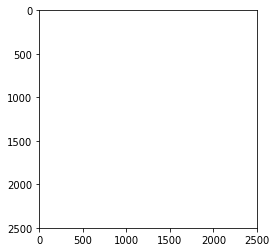

In [57]:
imshow(gt_img_res, cmap="gray")

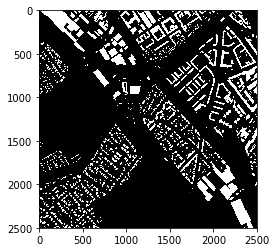

In [77]:
imshow(np.asarray(Image.open("./train/gt/vienna36.jpg").convert('RGB')))

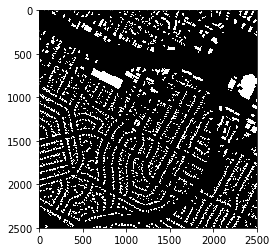

In [37]:
imshow(valid_gt_np[0].reshape(2500,2500), cmap='gray')

(1, 3, 2500, 2500)


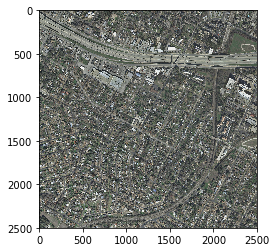

In [41]:
print(valid_img_np[0].shape)
imshow(np.moveaxis(valid_img_np[0].squeeze(0), 0, -1))